In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
from matplotlib import pyplot as plt
from matplotlib import ticker
import seaborn as sns
sns.set_theme()
sns_col = sns.color_palette()

######## Customer arrival parameters ########

# duration of initial wave in seconds
cust_peak_length = 3600
cust_peak_center = cust_peak_length // 2
# number of customers in the initial wave
cust_peak_count = 5000
# val=3 makes sure the edges of the peak are near zero
cust_peak_sigmas = 3

cust_peak_dist = st.truncnorm.rvs(
    -cust_peak_sigmas,
    cust_peak_sigmas,
    loc=cust_peak_center,
    scale=cust_peak_center / cust_peak_sigmas,
    size=cust_peak_count,
)

# steady state inflow, customers / second
cust_flow_rate = 0.8
cust_per_min = 60 * cust_flow_rate
cust_per_hour = 60 * cust_per_min
# steady state begin moment
cust_flow_start = cust_peak_center
# steady state end moment
cust_flow_end = cust_flow_start * 10
# total number of customers in the steady state flow
cust_flow_total = int((cust_flow_end - cust_flow_start) * cust_flow_rate)

# Generate customer arrival times distribution
cust_flow_dist = np.random.uniform(cust_flow_start, cust_flow_end, size=cust_flow_total)
cust_dist = np.concatenate((cust_peak_dist, cust_flow_dist)).astype(int)

######## Infrastructure parameters ########

# number of machines
M = 100

# processing time central value in seconds
proc_time_center = 120
# processing time minimum
proc_time_min = 30
# processing time maximum
proc_time_max = 240

# Generate pre-ordained processing times
proc_time_dist = np.random.triangular(proc_time_min, proc_time_center, proc_time_max, size=cust_dist.shape[0])

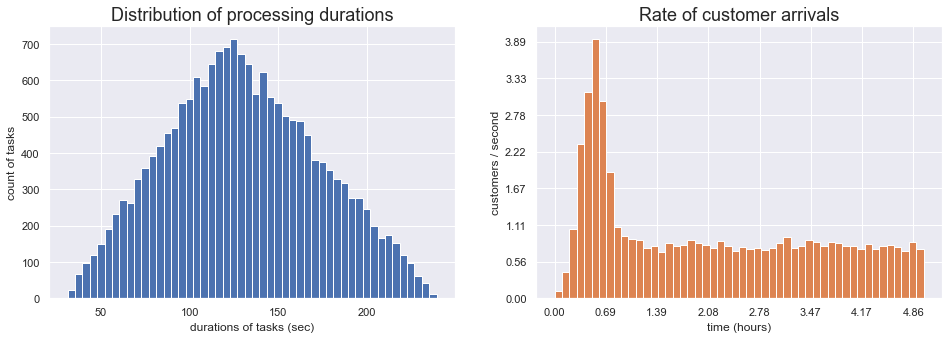

In [2]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
label_format = '{:,.2f}'
bins = 50

ax[0].hist(proc_time_dist, bins=50, color=sns_col[0])

ax[0].set_title("Distribution of processing durations", fontsize=18)
ax[0].set_xlabel("durations of tasks (sec)")
ax[0].set_ylabel("count of tasks")

ax[1].hist(cust_dist, bins=50, color=sns_col[1])
ax1_bin_width = cust_flow_end / bins

ax1_xticks_loc = ax[1].get_xticks().tolist()
ax[1].xaxis.set_major_locator(ticker.FixedLocator(ax1_xticks_loc))
ax[1].set_xticklabels([label_format.format(x / 3600) for x in ax1_xticks_loc])

ax1_yticks_loc = ax[1].get_yticks().tolist()
ax[1].yaxis.set_major_locator(ticker.FixedLocator(ax1_yticks_loc))
ax[1].set_yticklabels([label_format.format(y / ax1_bin_width) for y in ax1_yticks_loc])

ax[1].set_title("Rate of customer arrivals", fontsize=18)
ax[1].set_xlabel("time (hours)")
ax[1].set_ylabel("customers / second")
plt.show()

In [3]:
def avg_wait_time(mn, cust_dist, proc_time_dist, DEBUG=False):
    
    # the state of each machine
    # 0 = idle
    # 1 = busy
    machine = np.full((mn,), 0, dtype=int)
    
    # total number of customers
    c = cust_dist.shape[0]

    # status column:
    # -1 = not here yet
    # 0 = waiting customer
    # 1 = processing customer
    # 2 = customer is done
    state_dict = {
        "pt": proc_time_dist,  # pre-destined processing times
        "status": np.full((c,), -1, dtype=int),
        "machine": np.full((c,), -1, dtype=int),  # machine ID assigned to customer
        "time_went_in": cust_dist,  # arrival time
        "time_went_out": np.zeros((c,), dtype=int),  # task complete time
        "time_wait": np.zeros((c,), dtype=int),  # length of wait
    }
    state = pd.DataFrame(state_dict)
    
    # average wait times of currently waiting customers
    # updated every time increment
    proc_history = {
        'curr_wait_avg': [],
        'busy_machines': [],
        'waiting_cust': []
    }

    t = 0
    while True:
        
        #### update history
        # current average wait time for waiting and processing customers
        cwt = state[(state['status'] == 0) | (state['status'] == 1)]['time_wait'].mean()
        cwt = 0 if cwt != cwt else cwt
        proc_history['curr_wait_avg'] += [cwt]
        proc_history['busy_machines'] += [machine.sum()]
        proc_history['waiting_cust'] += [state[(state['status'] == 0) | (state['status'] == 1)].shape[0]]
        
        if DEBUG and t % 100 == 0:
            print(t, cwt, machine.sum(), proc_history['waiting_cust'][-1])
        
        # clock tick for waiting customers
        dfmask = (state['status'] == 0) | (state['status'] == 1)
        state.loc[dfmask, 'time_wait'] += 1
        
        # customers have just arrived, put them in the queue
        dfmask = (state["status"] == -1) & (t >= state["time_went_in"])
        state.loc[dfmask, "status"] = 0
        
        # processing has just completed for these customers
        # take them out of the machine pool
        dfmask = (state["status"] == 1) & (t - state["time_went_in"] >= state["pt"])
        state.loc[dfmask, "status"] = 2
        state.loc[dfmask, "time_went_out"] = t
        machines_go_idle = list(state.loc[dfmask, 'machine'].values)
        machine[machines_go_idle] = 0
        state.loc[dfmask, "machine"] = -1
        
        # find any idle machines
        # if there are any, find waiting customers for them
        idle_machines = list(np.where(machine == 0)[0])
        dfmask = (state['status'] == 0)
        waiting_customers = dfmask.loc[dfmask == True].index.to_list()
        if len(idle_machines) > 0 and len(waiting_customers) > 0:
            num_changes = min(len(idle_machines), len(waiting_customers))
            for i in range(0, num_changes):
                cust = waiting_customers[i]
                mach = idle_machines[i]
                machine[mach] = 1
                state.at[cust, "status"] = 1
                state.at[cust, "machine"] = mach
        
        if np.all((machine == 0)) and (state['status'] == 2).all():
            break
        
        t += 1
    return state, proc_history

In [4]:
%%time
final_state, proc_history = avg_wait_time(M, cust_dist, proc_time_dist)

Wall time: 1min 3s


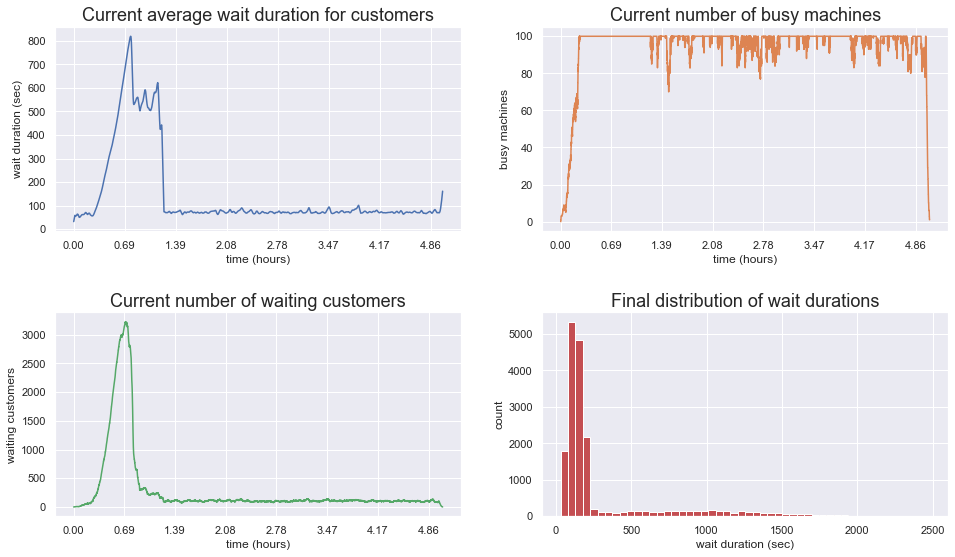

In [5]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 9))
plt.subplots_adjust(hspace = 0.4)

ax1.plot(np.convolve(proc_history['curr_wait_avg'], np.ones(100), 'valid') / 100, color=sns_col[0])
ax1.set_title("Current average wait duration for customers", fontsize=18)
ax1.set_xlabel("time (hours)")
ax1.set_ylabel("wait duration (sec)")
ax1_xticks_loc = ax1.get_xticks().tolist()
ax1.xaxis.set_major_locator(ticker.FixedLocator(ax1_xticks_loc))
ax1.set_xticklabels([label_format.format(x / 3600) for x in ax1_xticks_loc])

ax2.plot(proc_history['busy_machines'], color=sns_col[1])
ax2.set_title("Current number of busy machines", fontsize=18)
ax2.set_xlabel("time (hours)")
ax2.set_ylabel("busy machines")
ax2_xticks_loc = ax2.get_xticks().tolist()
ax2.xaxis.set_major_locator(ticker.FixedLocator(ax2_xticks_loc))
ax2.set_xticklabels([label_format.format(x / 3600) for x in ax2_xticks_loc])

ax3.plot(proc_history['waiting_cust'], color=sns_col[2])
ax3.set_title("Current number of waiting customers", fontsize=18)
ax3.set_xlabel("time (hours)")
ax3.set_ylabel("waiting customers")
ax3_xticks_loc = ax3.get_xticks().tolist()
ax3.xaxis.set_major_locator(ticker.FixedLocator(ax3_xticks_loc))
ax3.set_xticklabels([label_format.format(x / 3600) for x in ax3_xticks_loc])

ax4.hist(final_state['time_wait'], bins=50, color=sns_col[3])
ax4.set_title("Final distribution of wait durations", fontsize=18)
ax4.set_xlabel("wait duration (sec)")
ax4.set_ylabel("count")

plt.savefig("user_load.png", bbox_inches="tight")
plt.show()

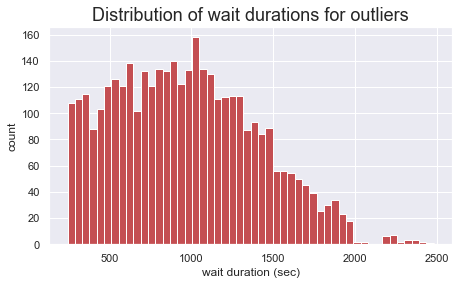

In [6]:
fig, ax = plt.subplots(figsize=(7.22, 4))
ax.hist(
    final_state[final_state["time_wait"] > proc_time_max]["time_wait"],
    bins=50,
    color=sns_col[3],
)
ax.set_title("Distribution of wait durations for outliers", fontsize=18)
ax.set_xlabel("wait duration (sec)")
ax.set_ylabel("count")
plt.savefig("outlier_wait.png", bbox_inches="tight")
plt.show()